In [248]:
import pandas as pd 
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
import mlflow
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec

### Metrique d'évaluation utilisé
Log Likelihood : Plus la vraisemblance logarithmique est élevée, meilleur est le modèle. Vous pouvez obtenir ce score en utilisant la méthode score de l'objet LDA.  
  
Perplexity : La perplexité est une mesure de la qualité du modèle. Une perplexité plus faible indique un meilleur modèle. Vous pouvez obtenir ce score en utilisant la méthode perplexity.  
  
Coherence Score : Le score de cohérence mesure la cohérence sémantique des sujets générés par le modèle LDA. Un score de cohérence plus élevé indique que les mots les plus importants d'un sujet sont plus sémantiquement similaires les uns aux autres. Le score de cohérence n'est pas directement disponible dans scikit-learn, mais peut être calculé en utilisant la bibliothèque Gensim.
  
### LDA.  
L'Analyse de la Répartition Latente de Dirichlet (LDA) est une technique de modélisation de sujets qui est largement utilisée en traitement du langage naturel. Elle permet de découvrir les sujets cachés dans un ensemble de documents en attribuant des distributions de probabilité à la fois aux documents (sur les sujets) et aux sujets (sur les mots), ce qui permet d'obtenir une représentation non supervisée et interprétable des données textuelles.



In [249]:
# Définir l'expérience MLflow
mlflow.set_experiment("mon_experiment")


<Experiment: artifact_location='file:///Users/bahia/Desktop/MLE_P5/mlruns/989834767278571594', creation_time=1711980329559, experiment_id='989834767278571594', last_update_time=1711980329559, lifecycle_stage='active', name='mon_experiment', tags={}>

In [250]:

# Pipeline avec les vectoriasations bag of words et tf-idf

class CustomCountVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = CountVectorizer(min_df=0.10, max_df=0.5, ngram_range=(1, 1), stop_words='english')

    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self

    def transform(self, X, y=None):
        return self.vectorizer.transform(X)
    
class CustomTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = TfidfVectorizer(min_df=0.10, max_df=0.5, ngram_range=(1, 1), stop_words='english')

    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self

    def transform(self, X, y=None):
        return self.vectorizer.transform(X)
    

from gensim.models import Word2Vec

class CustomWord2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size = 47, window=5, min_count=5, workers=4, negative=0):
        self.model = Word2Vec( window=window, vector_size = vector_size,min_count=min_count, workers=workers)

    def fit(self, X, y=None):
        self.model.build_vocab(X)
        return self

    def transform(self, X, y=None):
        # Moyenne des vecteurs de mots pour chaque document
        return np.array([np.mean([self.model.wv[w] for w in words if w in self.model.wv]
                                 or [np.zeros(self.model.vector_size)], axis=0)
                         for words in X])

pipeline_vec = Pipeline([
    ("count_vectorizer", CustomCountVectorizer())
])


def create_vectors_pipeline():
    pipeline_vec = Pipeline([
        ("count_vectorizer", CustomCountVectorizer())
    ])
    return pipeline_vec

def create_tfidf_pipeline():
    pipeline_tfidf = Pipeline([
        
        ("tfidf", CustomTfidfVectorizer())
    ])
    return pipeline_tfidf

def create_word2vec_pipeline():
    pipeline_word2vec = Pipeline([
        ("word2vec", CustomWord2VecVectorizer())
    ])
    return pipeline_word2vec





In [251]:
# Pipeline LDA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation

class LDAWithLogging(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=5, learning_decay=0.2, random_state=42):
        self.lda = LatentDirichletAllocation(n_components=n_components, learning_decay=learning_decay,random_state=random_state)
        #self.n_components = n_components
        #self.random_state = random_state
    def fit(self, X, y=None):
        self.lda.fit(X)
        return self

    def transform(self, X):
        document_topics = self.lda.transform(X)
        components = self.lda.components_
        log_likelihood = self.lda.score(X)
        perplexity = self.lda.perplexity(X)
        print(f"Log likelihood: {log_likelihood}")
        print(f"Perplexity: {perplexity}")
        mlflow.log_metric("log_likelihood", log_likelihood)
        mlflow.log_metric("perplexity", perplexity)
        for i, topic in enumerate(components):
            print(f"-------Topic {i}:--------")
            word_indices = topic.argsort()[-10:]
            topic_words = [feature_names[index] for index in word_indices]
            topic_weights = topic[word_indices]
            print(topic_words)
            plt.figure(figsize=(10, 5))
            plt.bar(topic_words, topic_weights)
            plt.title(f"Topic {i}")
            plt.savefig(f"topic_{i}.png")
            plt.show()
            # Enregistrer le fichier en tant qu'artefact
            mlflow.log_artifact(f"topic_{i}.png")
            pd.DataFrame(topic_words, columns=['word']).to_csv(f"topic_{i}.csv", index=False)
            mlflow.log_artifact(f"topic_{i}.csv")
           
        return document_topics

# Créer un pipeline avec le modèle LDA
lda_pipeline = Pipeline([
    ('lda', LDAWithLogging())
])

# Ajuster le pipeline aux données
'''with mlflow.start_run(nested=True):
    pipeline.fit(transformed_data)'''

'with mlflow.start_run(nested=True):\n    pipeline.fit(transformed_data)'

### Test avec CountVectorizer

Vectorizer la colonne Body

In [252]:
# Créer le pipeline de vectorisation
pipeline_vec = create_vectors_pipeline()

# Supposons que vous avez une DataFrame pandas X_fulltrain contenant les données textuelles dans une colonne 'body'
X_fulltrain = pd.read_csv("Data/X_train.csv", index_col=0, lineterminator='\n')

# Transformer les données textuelles en utilisant le pipeline
transformed_data_body = pipeline_vec.fit_transform(X_fulltrain.body)
print(transformed_data_body.shape)
# Obtenir le transformateur CustomCountVectorizer du pipeline
custom_count_vectorizer_body = pipeline_vec.named_steps['count_vectorizer']

# Obtenir les noms des caractéristiques (mots)
feature_names_body = custom_count_vectorizer_body.vectorizer.get_feature_names_out()

# Afficher les noms des caractéristiques
print(feature_names_body.shape)


(799, 47)
(47,)


Vectorizer la colonne title

In [253]:
pipeline_vec_title = create_vectors_pipeline()
# Supposons que vous avez une DataFrame pandas X_fulltrain contenant les données textuelles dans une colonne 'body'
X_fulltrain = pd.read_csv("Data/X_train.csv", index_col=0, lineterminator='\n')

# Transformer les données textuelles en utilisant le pipeline
transformed_data_title = pipeline_vec_title.fit_transform(X_fulltrain.title)
print(transformed_data_title.shape)
# Obtenir le transformateur CustomCountVectorizer du pipeline
custom_count_vectorizer_title = pipeline_vec_title.named_steps['count_vectorizer']

# Obtenir les noms des caractéristiques (mots)
feature_names = custom_count_vectorizer_title.vectorizer.get_feature_names_out()

# Afficher les noms des caractéristiques
print(feature_names.shape)

feature_names = np.concatenate((feature_names, feature_names_body))

(799, 1)
(1,)


In [254]:
# Concaténer les deux matrices
transformed_data = np.concatenate((transformed_data_title.toarray(), transformed_data_body.toarray()), axis=1)

# Vérifier la forme de la matrice combinée
print(transformed_data.shape)

(799, 48)


In [255]:
#mlflow.end_run()

In [256]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

'''# Définir les paramètres à tester
params = {
    'n_components': [5,10, 15, 20],  # nombre de sujets
    'learning_decay': [.2,.5, .7],  # facteur de décroissance pour le taux d'apprentissage
    'random_state': [1,25,42,]
}

# Créer un modèle LDA
lda = LatentDirichletAllocation()

# Créer une recherche sur grille
search = GridSearchCV(lda, param_grid=params, n_jobs=-1)

# Ajuster la recherche sur grille aux données
search.fit(transformed_data)

# Afficher les meilleurs paramètres
print("Best Model's Params: ", search.best_params_)

# Afficher la meilleure log-vraisemblance Score
print("Best Log Likelihood Score: ", search.best_score_)

# Afficher la perplexité du meilleur modèle
# Obtenir le meilleur modèle
best_lda_model = search.best_estimator_
print("Model Perplexity: ", best_lda_model.perplexity(transformed_data))'''

'# Définir les paramètres à tester\nparams = {\n    \'n_components\': [5,10, 15, 20],  # nombre de sujets\n    \'learning_decay\': [.2,.5, .7],  # facteur de décroissance pour le taux d\'apprentissage\n    \'random_state\': [1,25,42,]\n}\n\n# Créer un modèle LDA\nlda = LatentDirichletAllocation()\n\n# Créer une recherche sur grille\nsearch = GridSearchCV(lda, param_grid=params, n_jobs=-1)\n\n# Ajuster la recherche sur grille aux données\nsearch.fit(transformed_data)\n\n# Afficher les meilleurs paramètres\nprint("Best Model\'s Params: ", search.best_params_)\n\n# Afficher la meilleure log-vraisemblance Score\nprint("Best Log Likelihood Score: ", search.best_score_)\n\n# Afficher la perplexité du meilleur modèle\n# Obtenir le meilleur modèle\nbest_lda_model = search.best_estimator_\nprint("Model Perplexity: ", best_lda_model.perplexity(transformed_data))'

Appliquer LDA sur les données transformé

Log likelihood: -41085.00960290709
Perplexity: 40.24667512294105
-------Topic 0:--------
['implement', 'google', 'look', 'example', 'update', 'question', 'class', 'code', 'user', 'view']


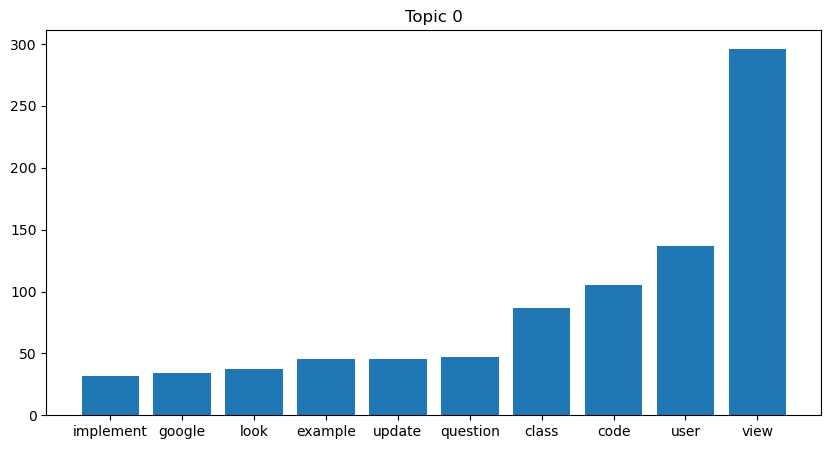

-------Topic 1:--------
['error', 'app', 'start', 'problem', 'way', 'implement', 'class', 'activity', 'method', 'fragment']


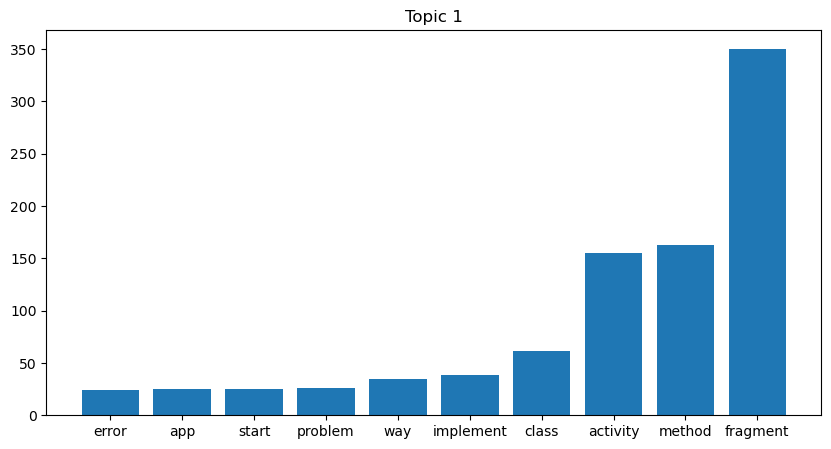

-------Topic 2:--------
['try', 'android', 'app', 'support', 'work', 'error', 'version', 'project', 'android', 'file']


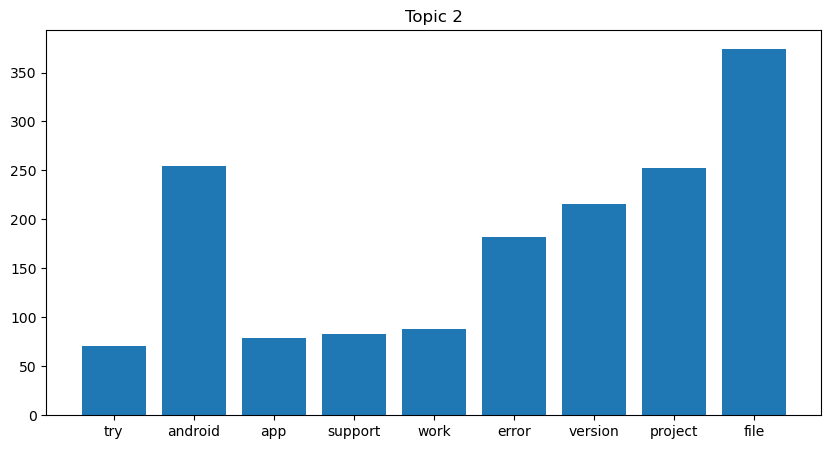

-------Topic 3:--------
['problem', 'code', 'change', 'run', 'way', 'create', 'follow', 'error', 'work', 'try']


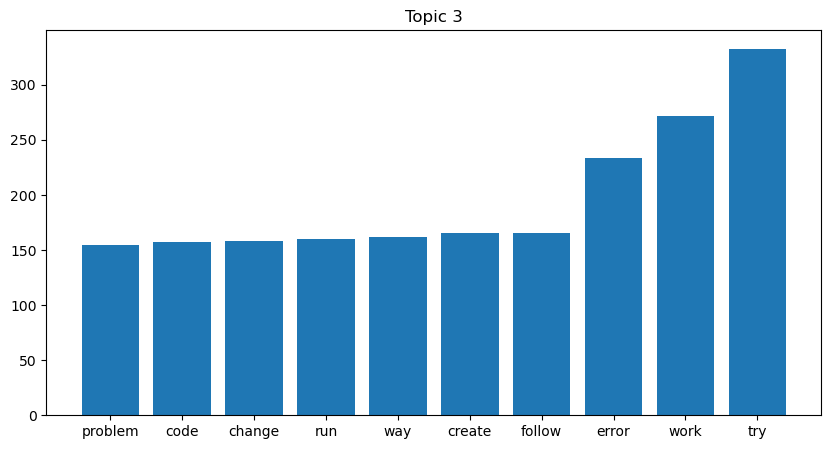

-------Topic 4:--------
['create', 'try', 'code', 'method', 'set', 'class', 'string', 'return', 'override', 'void']


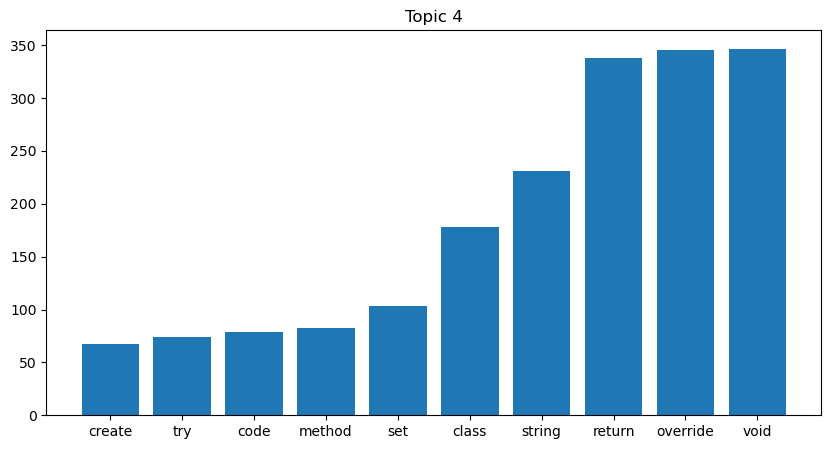

In [257]:
# Ajuster le pipeline aux données
with mlflow.start_run(nested=True):
    lda_pipeline.fit_transform(transformed_data)
mlflow.end_run()

## Test avec la vectorisation Tf_Idf

In [258]:
# Créer le pipeline de vectorisation
pipeline_tfidf = create_tfidf_pipeline()

#  X_fulltrain contenant les données textuelles dans une colonne 'body'
X_fulltrain = pd.read_csv("Data/X_train.csv", index_col=0, lineterminator='\n')

# Transformer les données textuelles en utilisant le pipeline
transformed_data_body_tf = pipeline_tfidf.fit_transform(X_fulltrain.body)
print(transformed_data_body_tf.shape)
# Obtenir le transformateur CustomCountTf du pipeline
custom_count_tf_body = pipeline_tfidf.named_steps['tfidf']
# Obtenir les noms des caractéristiques 
feature_names_body = custom_count_tf_body.vectorizer.get_feature_names_out()

# Afficher les noms des caractéristiques
print(feature_names_body.shape)
print(feature_names_body)


(799, 47)
(47,)
['activity' 'add' 'android' 'app' 'application' 'change' 'class' 'code'
 'create' 'data' 'doesnt' 'dont' 'error' 'example' 'file' 'follow'
 'fragment' 'google' 'help' 'implement' 'issue' 'know' 'look' 'make'
 'method' 'override' 'problem' 'project' 'question' 'return' 'run' 'set'
 'solution' 'start' 'string' 'support' 'thanks' 'time' 'true' 'try'
 'update' 'user' 'version' 'view' 'void' 'way' 'work']


In [259]:
# Créer le pipeline de vectorisation
pipeline_tfidf = create_tfidf_pipeline()
# Supposons que vous avez une DataFrame pandas X_fulltrain contenant les données textuelles dans une colonne 'body'
X_fulltrain = pd.read_csv("Data/X_train.csv", index_col=0, lineterminator='\n')

# Transformer les données textuelles en utilisant le pipeline
transformed_data_title = pipeline_tfidf.fit_transform(X_fulltrain.title)
print(transformed_data_title.shape)
# Obtenir le transformateur tdidf du pipeline
custom_count_vectorizer_title = pipeline_tfidf.named_steps['tfidf']

# Obtenir les noms des caractéristiques (mots)
feature_names = custom_count_tf_body.vectorizer.get_feature_names_out()

# Afficher les noms des caractéristiques
print(feature_names.shape)

feature_names = np.concatenate((feature_names, feature_names_body))
print(feature_names_body)

(799, 1)
(47,)
['activity' 'add' 'android' 'app' 'application' 'change' 'class' 'code'
 'create' 'data' 'doesnt' 'dont' 'error' 'example' 'file' 'follow'
 'fragment' 'google' 'help' 'implement' 'issue' 'know' 'look' 'make'
 'method' 'override' 'problem' 'project' 'question' 'return' 'run' 'set'
 'solution' 'start' 'string' 'support' 'thanks' 'time' 'true' 'try'
 'update' 'user' 'version' 'view' 'void' 'way' 'work']


In [260]:
# Concaténer les deux matrices
transformed_data = np.concatenate((transformed_data_title.toarray(), transformed_data_body.toarray()), axis=1)

# Vérifier la forme de la matrice combinée
print(transformed_data.shape)

(799, 48)


Log likelihood: -8470.488250487486
Perplexity: 103.40927789271434
-------Topic 0:--------
['app', 'application', 'start', 'change', 'code', 'run', 'work', 'try', 'user', 'error']


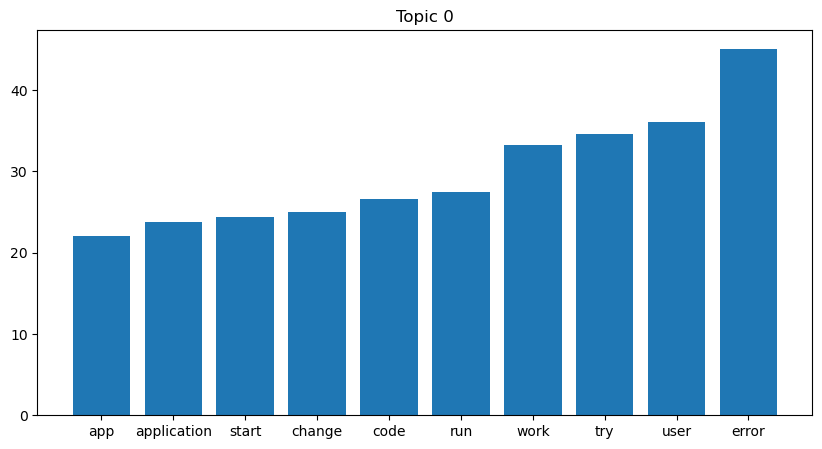

-------Topic 1:--------
['app', 'code', 'return', 'view', 'class', 'method', 'override', 'void', 'activity', 'fragment']


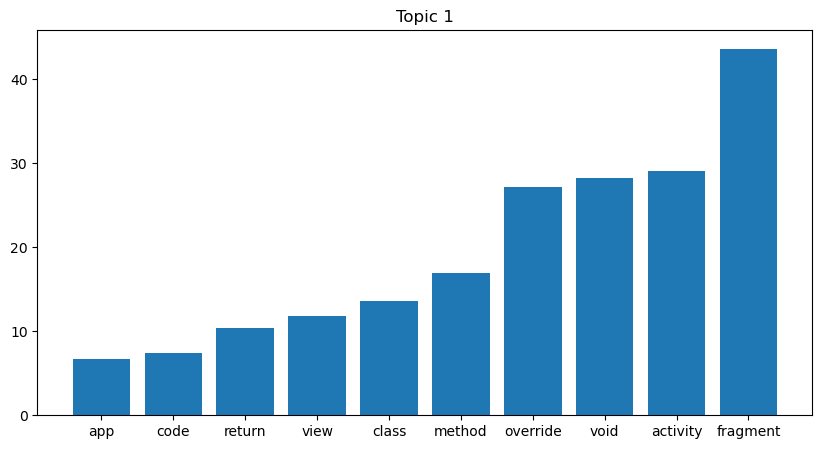

-------Topic 2:--------
['problem', 'work', 'error', 'solution', 'version', 'support', 'google', 'file', 'android', 'project']


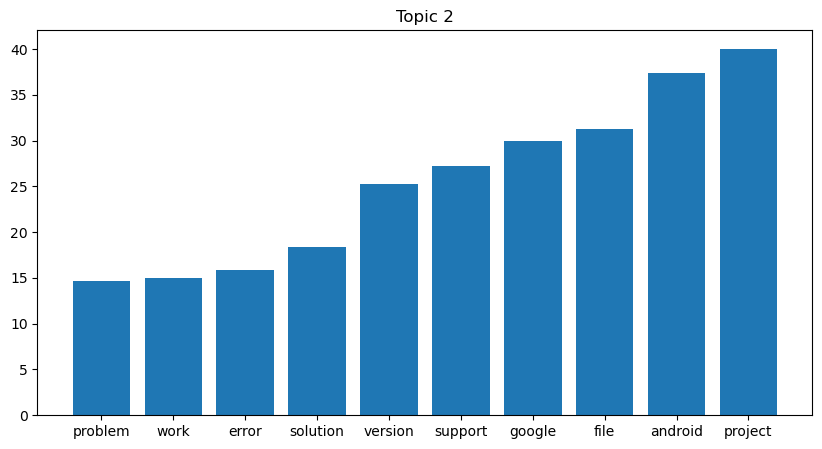

-------Topic 3:--------
['true', 'code', 'make', 'implement', 'look', 'question', 'dont', 'know', 'way', 'example']


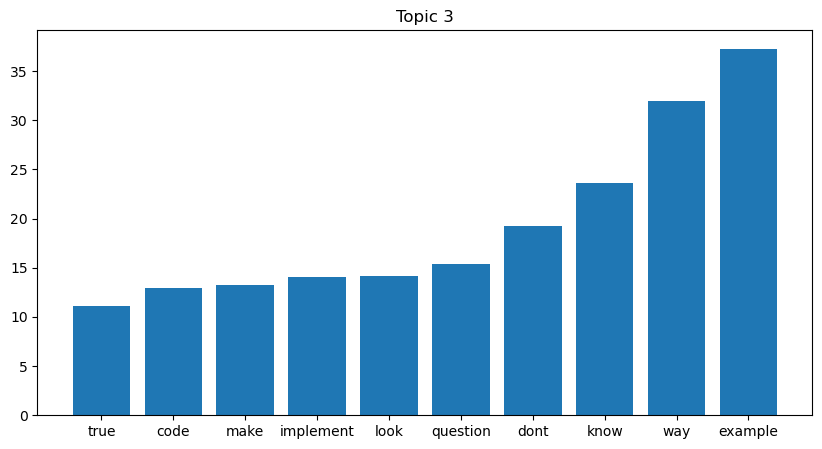

-------Topic 4:--------
['code', 'follow', 'try', 'set', 'data', 'class', 'create', 'return', 'string', 'view']


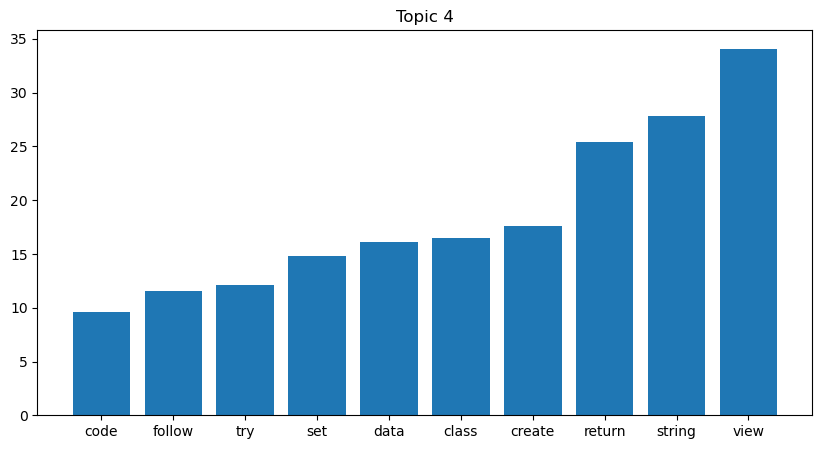

{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.2, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 5, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [261]:
# Ajuster le pipeline aux données
with mlflow.start_run(nested=True):
    lda_pipeline.fit_transform(transformed_data_body_tf)
    print(lda_pipeline.named_steps['lda'].lda.get_params())
mlflow.end_run()


## Essais avec Word2Vec

In [262]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize

# Tokeniser les documents
#X_fulltrain['body'] = X_fulltrain['body'].apply(word_tokenize)


# Tokeniser les documents
X_fulltrain['body'] = X_fulltrain['body'].apply(word_tokenize)
pipeline_word2vec = create_word2vec_pipeline()
# Transformer les données textuelles en utilisant le pipeline
transformed_data_body_word2vec = pipeline_word2vec.fit_transform(X_fulltrain.body)
print(transformed_data_body_word2vec.shape)

# Afficher les données transformées

transformed_data_body_word2vec -= transformed_data_body_word2vec.min()
print(transformed_data_body_word2vec)

(799, 47)
[[0.01607828 0.01393479 0.01234226 ... 0.01473806 0.01840197 0.0160606 ]
 [0.01767067 0.02009894 0.01838111 ... 0.0176429  0.01891943 0.01702096]
 [0.01981821 0.02043975 0.01636398 ... 0.01748153 0.01972663 0.01372901]
 ...
 [0.01971417 0.01519161 0.01841761 ... 0.02125416 0.01871583 0.01986498]
 [0.01842239 0.0145977  0.01824672 ... 0.01520267 0.0194429  0.01180591]
 [0.0171757  0.01294021 0.01757088 ... 0.01662006 0.0167654  0.01521986]]


In [263]:
# Obtenir le transformateur Word2Vec du pipeline
custom_word2vec = pipeline_word2vec.named_steps['word2vec']

# Obtenir le modèle Word2Vec
model = custom_word2vec.model

# Obtenir les mots du vocabulaire
words = list(model.wv.key_to_index)

# Obtenir les vecteurs correspondant à ces mots
vectors = [model.wv[word] for word in words]

# Créer un DataFrame avec les mots et les vecteurs
df = pd.DataFrame(vectors, index=words)

# Afficher le DataFrame
display(df)

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
try,-0.001141,0.000503,0.010858,0.019169,-0.019794,-0.015142,0.013742,0.019091,-0.010671,-0.008007,...,-0.012619,0.000096,-0.010114,-0.020433,0.010654,-0.018637,-0.009344,-0.000075,-0.000630,-0.016301
error,0.020457,0.010600,0.019645,-0.017357,0.009566,-0.008802,0.001754,0.018082,-0.009494,0.009612,...,-0.012134,0.003955,0.012955,-0.010209,-0.006611,0.014463,0.003471,0.000404,0.007391,0.000463
work,0.020466,0.010767,-0.018973,-0.014982,0.001918,0.013601,-0.018340,0.007799,0.011042,0.012217,...,-0.009282,-0.001275,-0.012118,0.008193,0.005929,0.014662,0.012981,0.020295,0.019731,0.016804
eandroidruntime,-0.014871,-0.019481,-0.000757,-0.006595,0.016796,0.012635,-0.003289,0.003215,0.003809,0.016633,...,0.010943,-0.007798,-0.019936,0.008142,0.010393,-0.013678,0.002571,-0.004415,0.000052,-0.021029
code,0.005728,-0.010107,0.002314,-0.003354,0.004674,-0.016769,-0.005781,0.005666,0.011376,-0.005088,...,-0.010306,0.017923,0.011197,-0.013936,0.008421,0.011639,-0.015801,-0.015757,-0.005266,-0.018353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
possibility,-0.018634,-0.013934,0.002103,-0.009520,-0.013704,0.015915,-0.006065,0.004968,-0.004977,-0.010489,...,-0.005718,0.001776,0.012433,0.006742,-0.018277,0.000404,-0.011125,-0.012469,0.008641,0.006981
androidlayoutgravitybottom,-0.010993,-0.018093,0.015383,0.020737,-0.016299,-0.013466,-0.020456,-0.001639,0.019586,-0.008304,...,0.012612,-0.020040,0.000319,0.010625,-0.002018,-0.017499,-0.003380,0.008600,0.014014,0.018480
blank,-0.016594,0.016617,0.014752,0.012308,-0.014387,0.021072,0.011096,0.006915,-0.011601,-0.013991,...,0.018319,0.013891,0.004412,-0.010565,0.003589,-0.019618,-0.004626,-0.009281,0.006556,0.009046
origin,0.006446,-0.005504,0.012964,-0.002133,0.020560,-0.000157,0.017691,-0.006786,-0.008195,0.014050,...,0.002381,-0.016576,0.004918,-0.009943,-0.009911,0.001587,-0.011111,-0.020900,0.015741,0.017293


In [264]:
# Définir les paramètres à tester
'''params = {
    'n_components': [2,3,4,5],  # nombre de sujets
    'learning_decay': [.2,.5, .7],  # facteur de décroissance pour le taux d'apprentissage
    'random_state': [1,25,42,]
}

# Créer un modèle LDA
lda = LatentDirichletAllocation()

# Créer une recherche sur grille
search = GridSearchCV(lda, param_grid=params, n_jobs=-1)

# Ajuster la recherche sur grille aux données
search.fit(transformed_data_body_word2vec)

# Afficher les meilleurs paramètres
print("Best Model's Params: ", search.best_params_)

# Afficher la meilleure log-vraisemblance Score
print("Best Log Likelihood Score: ", search.best_score_)

# Afficher la perplexité du meilleur modèle
# Obtenir le meilleur modèle
best_lda_model = search.best_estimator_
print("Model Perplexity: ", best_lda_model.perplexity(transformed_data_body_word2vec))'''

'params = {\n    \'n_components\': [2,3,4,5],  # nombre de sujets\n    \'learning_decay\': [.2,.5, .7],  # facteur de décroissance pour le taux d\'apprentissage\n    \'random_state\': [1,25,42,]\n}\n\n# Créer un modèle LDA\nlda = LatentDirichletAllocation()\n\n# Créer une recherche sur grille\nsearch = GridSearchCV(lda, param_grid=params, n_jobs=-1)\n\n# Ajuster la recherche sur grille aux données\nsearch.fit(transformed_data_body_word2vec)\n\n# Afficher les meilleurs paramètres\nprint("Best Model\'s Params: ", search.best_params_)\n\n# Afficher la meilleure log-vraisemblance Score\nprint("Best Log Likelihood Score: ", search.best_score_)\n\n# Afficher la perplexité du meilleur modèle\n# Obtenir le meilleur modèle\nbest_lda_model = search.best_estimator_\nprint("Model Perplexity: ", best_lda_model.perplexity(transformed_data_body_word2vec))'

Log likelihood: -2852.4884638786316
Perplexity: 94.82258586347628
-------Topic 0:--------
['time', 'true', 'make', 'file', 'follow', 'void', 'way', 'activity', 'class', 'project']


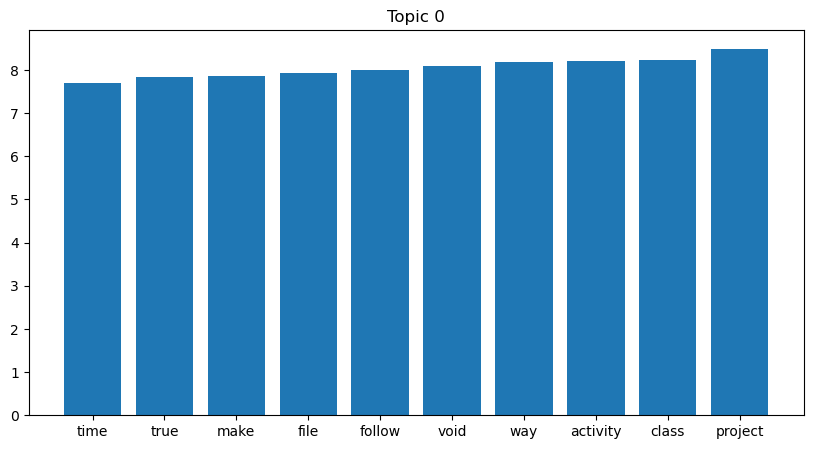

-------Topic 1:--------
['update', 'android', 'error', 'return', 'add', 'doesnt', 'method', 'view', 'try', 'code']


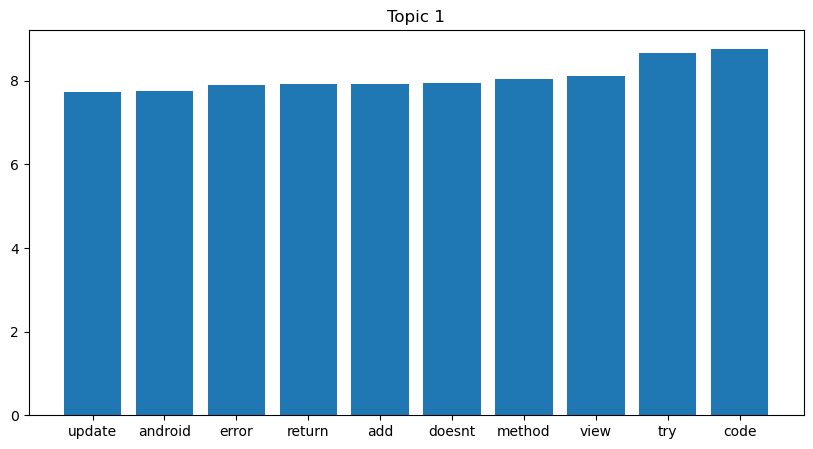

In [265]:
# Créer un instance du modèle LDA avec les nouveaux paramètres
lda_model = LDAWithLogging(n_components=2, random_state=1)

# Remplacer l'instance du modèle LDA dans le pipeline
lda_pipeline.set_params(lda=lda_model)

# Ajuster le pipeline aux données et enregistrer les résultats dans MLflow
with mlflow.start_run():
    lda_pipeline.fit_transform(transformed_data_body_word2vec)
mlflow.end_run()